## elo_world_high_score_without_blending
- Referenced from https://www.kaggle.com/gpreda/elo-world-high-score-without-blending

In [ ]:
import gc
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

In [2]:
#load data
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
historical_trans_df = pd.read_csv('../input/historical_transactions.csv')
new_merchant_trans_df = pd.read_csv('../input/new_merchant_transactions.csv')

In [3]:
#process NAs
print('Start processing NAs')
#process NA2 for transactions
for df in [historical_trans_df, new_merchant_trans_df]:
    df['category_2'].fillna(1.0, inplace=True)
    df['category_3'].fillna('A', inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a', inplace=True)

Start processing NAs


In [4]:
#define function for aggregation
def create_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [5]:
print('process historical and new merchant datasets')
for df in [historical_trans_df, new_merchant_trans_df]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    df['category_3'] = df['category_3'].map({'A':0, 'B':1, 'C':2}) 
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days) // 30
    df['month_diff'] += df['month_lag']

process historical and new merchant datasets


In [6]:
#define aggregations with historical_trans_df
print('Aggregate historical trans')
aggs = {}
for col in ['subsector_id','merchant_id','merchant_category_id', 'state_id', 'city_id']:
    aggs[col] = ['nunique']
for col in ['month', 'hour', 'weekofyear', 'dayofweek']:
    aggs[col] = ['nunique', 'mean', 'min', 'max']
    
aggs['purchase_amount'] = ['sum','max','min','mean','var', 'std']
aggs['installments'] = ['sum','max','min','mean','var', 'std']
aggs['purchase_date'] = ['max','min', 'nunique']
aggs['month_lag'] = ['max','min','mean','var','nunique']
aggs['month_diff'] = ['mean', 'min', 'max', 'var','nunique']
aggs['authorized_flag'] = ['sum', 'mean', 'nunique']
aggs['weekend'] = ['sum', 'mean', 'nunique']
aggs['year'] = ['nunique', 'mean']
aggs['category_1'] = ['sum', 'mean', 'min', 'max', 'nunique', 'std']
aggs['category_2'] = ['sum', 'mean', 'min', 'nunique', 'std']
aggs['category_3'] = ['sum', 'mean', 'min', 'nunique', 'std']
aggs['card_id'] = ['size', 'count']

Aggregate historical trans


In [7]:
for col in ['category_2','category_3']:
    historical_trans_df[col+'_mean'] = historical_trans_df.groupby([col])['purchase_amount'].transform('mean')
    historical_trans_df[col+'_min'] = historical_trans_df.groupby([col])['purchase_amount'].transform('min')
    historical_trans_df[col+'_max'] = historical_trans_df.groupby([col])['purchase_amount'].transform('max')
    historical_trans_df[col+'_sum'] = historical_trans_df.groupby([col])['purchase_amount'].transform('sum')
    historical_trans_df[col+'_std'] = historical_trans_df.groupby([col])['purchase_amount'].transform('std')
    aggs[col+'_mean'] = ['mean']    

new_columns = create_new_columns('hist',aggs)
historical_trans_group_df = historical_trans_df.groupby('card_id').agg(aggs)
historical_trans_group_df.columns = new_columns
historical_trans_group_df.reset_index(drop=False,inplace=True)
historical_trans_group_df['hist_purchase_date_diff'] =\
    (historical_trans_group_df['hist_purchase_date_max'] - historical_trans_group_df['hist_purchase_date_min']).dt.days
historical_trans_group_df['hist_purchase_date_average'] =\
    historical_trans_group_df['hist_purchase_date_diff'] / historical_trans_group_df['hist_card_id_size']
historical_trans_group_df['hist_purchase_date_uptonow'] =\
    (datetime.datetime.today() - historical_trans_group_df['hist_purchase_date_max']).dt.days
historical_trans_group_df['hist_purchase_date_uptomin'] =\
    (datetime.datetime.today() - historical_trans_group_df['hist_purchase_date_min']).dt.days

In [8]:
#merge with train, test
train_df = train_df.merge(historical_trans_group_df,
                          on='card_id',
                          how='left')
test_df = test_df.merge(historical_trans_group_df,
                        on='card_id',
                        how='left')

In [9]:
#cleanup memory
del historical_trans_group_df;
gc.collect()

35

In [10]:
#define aggregations with new_merchant_trans_df 
print('Aggregate new merchant trans')
aggs = {}
for col in ['subsector_id','merchant_id','merchant_category_id','state_id', 'city_id']:
    aggs[col] = ['nunique']
for col in ['month', 'hour', 'weekofyear', 'dayofweek']:
    aggs[col] = ['nunique', 'mean', 'min', 'max']

aggs['purchase_amount'] = ['sum','max','min','mean','var','std']
aggs['installments'] = ['sum','max','min','mean','var','std']
aggs['purchase_date'] = ['max','min', 'nunique']
aggs['month_lag'] = ['max','min','mean','var', 'nunique']
aggs['month_diff'] = ['mean', 'max', 'min', 'var','nunique']
aggs['weekend'] = ['sum', 'mean', 'nunique']
aggs['year'] = ['nunique', 'mean']
aggs['category_1'] = ['sum', 'mean', 'min', 'nunique']
aggs['category_2'] = ['sum', 'mean', 'min', 'nunique']
aggs['category_3'] = ['sum', 'mean', 'min', 'nunique']
aggs['card_id'] = ['size', 'count']

Aggregate new merchant trans


In [11]:
for col in ['category_2','category_3']:
    new_merchant_trans_df[col+'_mean'] = new_merchant_trans_df.groupby([col])['purchase_amount'].transform('mean')
    new_merchant_trans_df[col+'_min'] = new_merchant_trans_df.groupby([col])['purchase_amount'].transform('min')
    new_merchant_trans_df[col+'_max'] = new_merchant_trans_df.groupby([col])['purchase_amount'].transform('max')
    new_merchant_trans_df[col+'_sum'] = new_merchant_trans_df.groupby([col])['purchase_amount'].transform('sum')
    new_merchant_trans_df[col+'_std'] = new_merchant_trans_df.groupby([col])['purchase_amount'].transform('std')
    aggs[col+'_mean'] = ['mean']

new_columns = create_new_columns('new_hist',aggs)
new_merchant_trans_group_df = new_merchant_trans_df.groupby('card_id').agg(aggs)
new_merchant_trans_group_df.columns = new_columns
new_merchant_trans_group_df.reset_index(drop=False,inplace=True)
new_merchant_trans_group_df['new_hist_purchase_date_diff'] =\
    (new_merchant_trans_group_df['new_hist_purchase_date_max'] - new_merchant_trans_group_df['new_hist_purchase_date_min']).dt.days
new_merchant_trans_group_df['new_hist_purchase_date_average']\
    = new_merchant_trans_group_df['new_hist_purchase_date_diff']/new_merchant_trans_group_df['new_hist_card_id_size']
new_merchant_trans_group_df['new_hist_purchase_date_uptonow'] =\
    (datetime.datetime.today() - new_merchant_trans_group_df['new_hist_purchase_date_max']).dt.days
new_merchant_trans_group_df['new_hist_purchase_date_uptomin'] =\
    (datetime.datetime.today() - new_merchant_trans_group_df['new_hist_purchase_date_min']).dt.days

In [12]:
#merge with train, test
train_df = train_df.merge(new_merchant_trans_group_df,
                          on='card_id',
                          how='left')
test_df = test_df.merge(new_merchant_trans_group_df,
                        on='card_id',
                        how='left')

In [13]:
#clean-up memory
del new_merchant_trans_group_df;
gc.collect()
del historical_trans_df;
gc.collect()
del new_merchant_trans_df;
gc.collect()

0

In [14]:
#process train
print('Process train')
train_df['outliers'] = 0
train_df.loc[train_df['target'] < -30, 'outliers'] = 1
outls = train_df['outliers'].value_counts()
print("Outliers: {}".format(outls))

Process train
Outliers: 0    199710
1      2207
Name: outliers, dtype: int64


In [15]:
print('Process train and test')
## process both train and test
for df in [train_df, test_df]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['dayofyear'] = df['first_active_month'].dt.dayofyear
    df['quarter'] = df['first_active_month'].dt.quarter
    df['is_month_start'] = df['first_active_month'].dt.is_month_start
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['hist_last_buy'] = (df['hist_purchase_date_max'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_last_buy'] = (df['new_hist_purchase_date_max'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max', 'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['card_id_cnt_total'] = df['new_hist_card_id_count']+df['hist_card_id_count']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']
    df['purchase_amount_mean'] = df['new_hist_purchase_amount_mean']+df['hist_purchase_amount_mean']
    df['purchase_amount_max'] = df['new_hist_purchase_amount_max']+df['hist_purchase_amount_max']

Process train and test


In [16]:
for f in ['feature_1','feature_2','feature_3']:
    order_label = train_df.groupby([f])['outliers'].mean()
    train_df[f] = train_df[f].map(order_label)
    test_df[f] = test_df[f].map(order_label)

In [17]:
train_columns = [c for c in train_df.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = train_df['target']
del train_df['target']

In [18]:
##model params
print('Prepare model.')
param = {'num_leaves': 51,
         'min_data_in_leaf': 35, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.008,
         "boosting": "gbdt",
         "feature_fraction": 0.85,
         "bagging_freq": 1,
         "bagging_fraction": 0.82,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.11,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 2019}
#prepare fit model with cross-validation
folds = StratifiedKFold(n_splits=9, shuffle=True, random_state=2019)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

Prepare model


In [19]:
#run model
print('Start running model.')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df,train_df['outliers'].values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=200,
                    early_stopping_rounds=150)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(test_df[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
strRMSE = "".format(np.sqrt(mean_squared_error(oof, target)))
print(strRMSE)

Start running model
fold 0
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.569	valid_1's rmse: 3.69027
[400]	training's rmse: 3.4679	valid_1's rmse: 3.66433
[600]	training's rmse: 3.40364	valid_1's rmse: 3.65637
[800]	training's rmse: 3.35111	valid_1's rmse: 3.65261
[1000]	training's rmse: 3.30521	valid_1's rmse: 3.65016
[1200]	training's rmse: 3.26393	valid_1's rmse: 3.64904
[1400]	training's rmse: 3.22524	valid_1's rmse: 3.64896
[1600]	training's rmse: 3.18878	valid_1's rmse: 3.649
Early stopping, best iteration is:
[1490]	training's rmse: 3.20855	valid_1's rmse: 3.64836
fold 1
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.56844	valid_1's rmse: 3.68676
[400]	training's rmse: 3.46723	valid_1's rmse: 3.66497
[600]	training's rmse: 3.40153	valid_1's rmse: 3.6581
[800]	training's rmse: 3.34895	valid_1's rmse: 3.65482
Early stopping, best iteration is:
[829]	training's rmse: 3.34198	valid_1's rmse: 3.65422
f

Feature importance plot


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


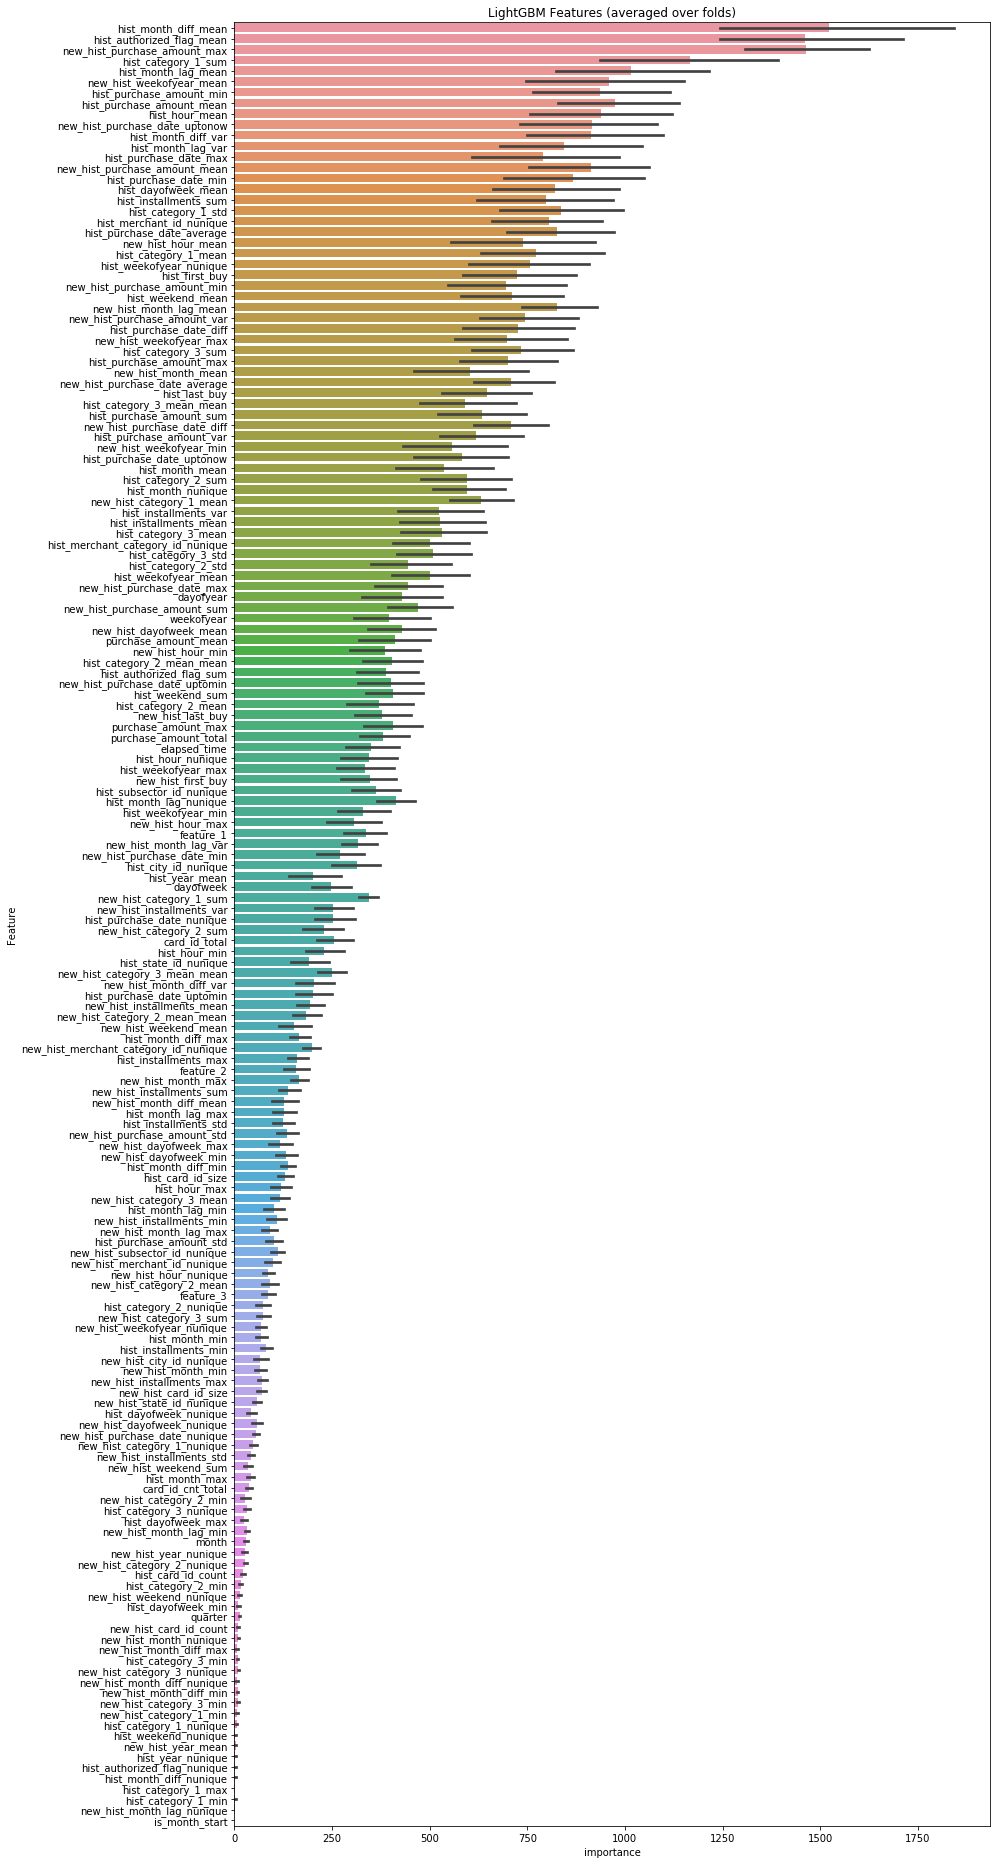

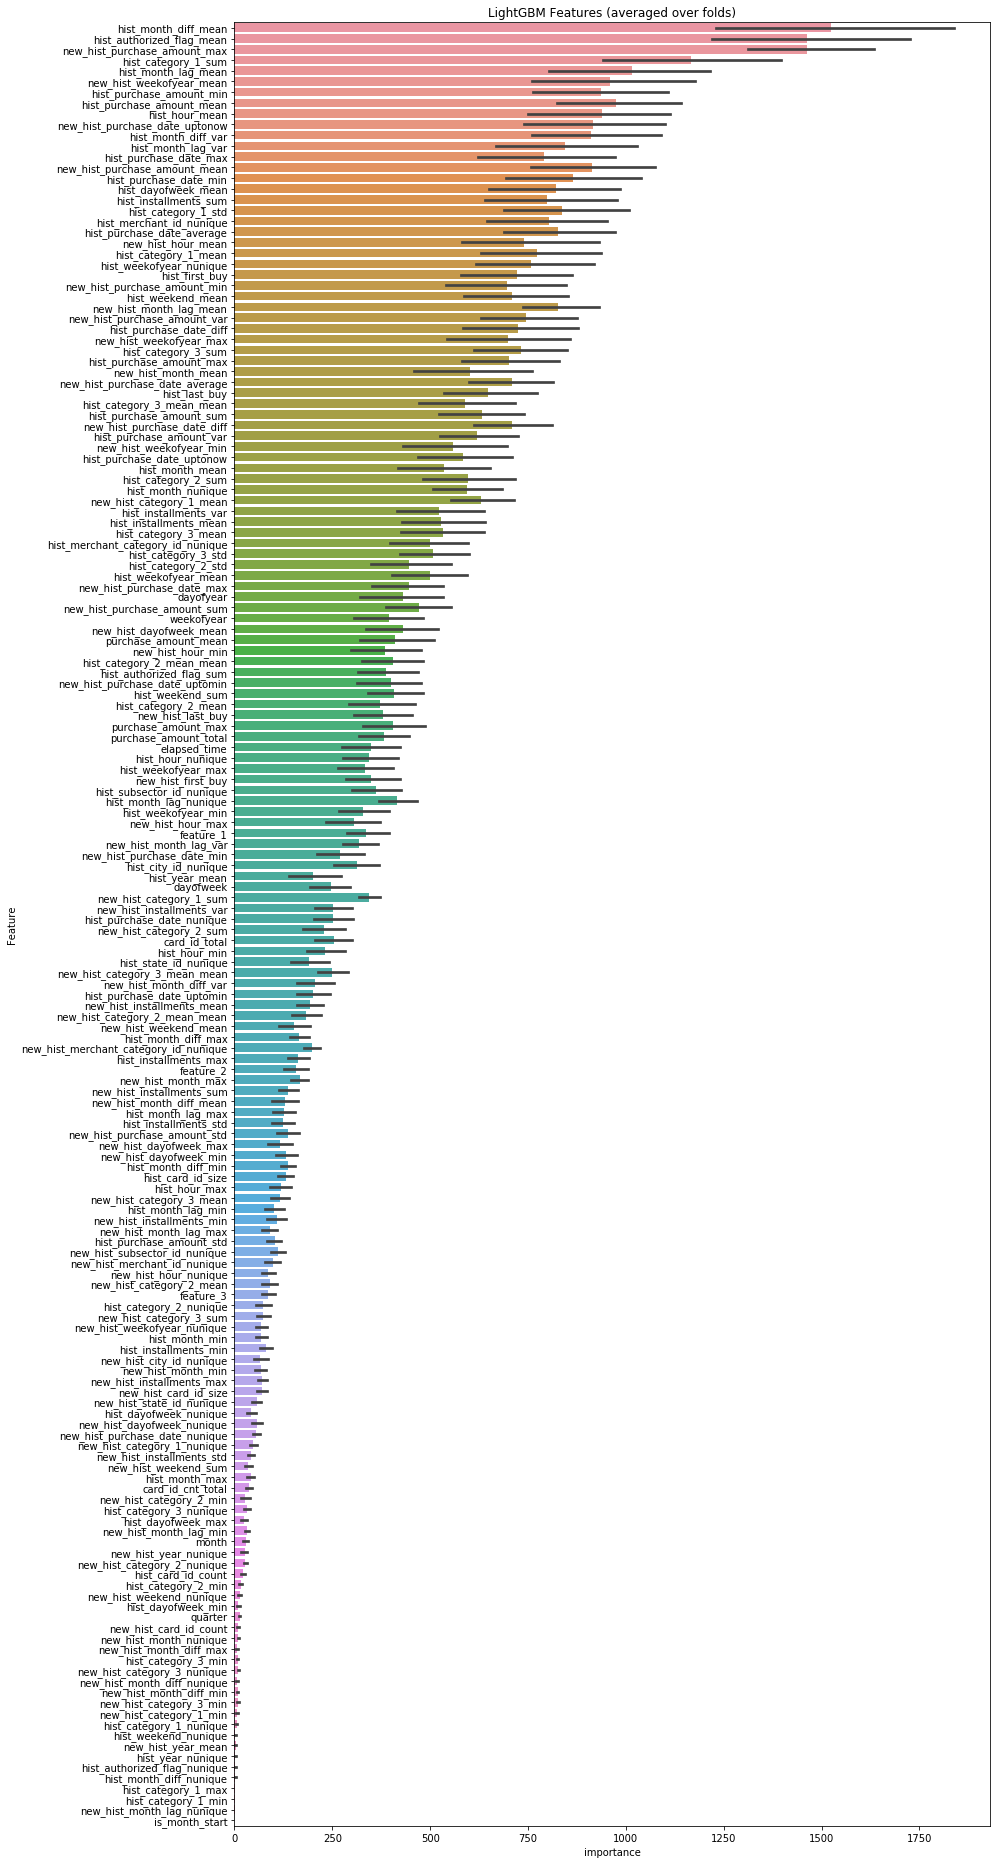

In [22]:
##plot the feature importance
print("Feature importance plot")
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
plt.figure(figsize=(14,26))
sns.barplot(x='importance', y='Feature', data=best_features.sort_values(by='importance',ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.show()

In [21]:
##submission
print("Prepare submission.")
sub_df = pd.DataFrame({"card_id": test_df["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("lgb_best_score.csv", index=False)

Prepare submission
